In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as pl
import scipy.stats as stats
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn import svm
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.model_selection import train_test_split
from datetime import datetime



In [2]:
df = pd.read_csv('sap_storing_data_hu_project.csv')

C:\Users\emiel\anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3165: DtypeWarning: Columns (0,11,19,21,24,25,27,32,33,36,37,38,39,40,46,47,48,49,51,53,55,56,60,73,75,78,80,82,83,86,87,91,95,99,102,103,104,107,108,109,110,111,112,113,116,118,119,120,121,122,123,124,129) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [3]:
def column_outlier(strength, dataframe, columns):
    temp_dataframe = dataframe.copy()
    try:
        if strength == 's':
            strength=3
        elif strength == 'a':
            strength=1.5
    except:
        print("Invalid strength")
    for column in columns:
        Q1 = temp_dataframe[column].quantile(0.25)
        Q3 = temp_dataframe[column].quantile(0.75)
        IQR = Q3 - Q1
        temp_dataframe = temp_dataframe[~((temp_dataframe[column] < (Q1 - strength * IQR)) |(temp_dataframe[column] > (Q3 + strength* IQR)))]
    return temp_dataframe

<h2>Data Cleaning </h2>

In [4]:
# ik zorg er hier voor dat de 'stm_progfh_in_duur' kolom naar floats gecast wordt
df.stm_progfh_in_duur = df.stm_progfh_in_duur.apply(lambda x: float(str(x).replace('-','').replace('*','').strip()))

# delete stm_fh_duur outliers
#df = column_outlier('a', df.copy(), ['stm_fh_duur'])


# voeg dummy kolommen voor seizoenen toe
df.stm_sap_melddatum = pd.to_datetime(df.stm_sap_melddatum)

df['date_offset'] = (df.stm_sap_melddatum.dt.month*100 + df.stm_sap_melddatum.dt.day - 320)%1300

df['seizoen_melding'] = pd.cut(df['date_offset'], [0, 300, 602, 900, 1300], 
                      labels=['spring', 'summer', 'autumn', 'winter'])

df.drop(['date_offset'], axis=1)
df = df.join(pd.get_dummies(df.seizoen_melding))

# join de oorzaakcodes
o_df = pd.read_csv('Oorzaakcodes.csv', sep = ';')
o_df = o_df.rename(columns={'Code': 'stm_oorz_code'})
df = df.merge(o_df, on = 'stm_oorz_code', how = 'outer')

In [5]:
pd.set_option('display.max_rows', None)

In [6]:
pd.set_option('display.max_columns', None)

In [7]:
df.drop(df[df.stm_fh_duur == 0].index, inplace=True)

In [8]:
df.stm_fh_duur.describe()

count    726775.000000
mean       1141.258427
std        7103.560208
min           1.000000
25%          54.000000
50%         120.000000
75%         378.000000
max      528297.000000
Name: stm_fh_duur, dtype: float64

In [9]:
new_df_copy = column_outlier('a', df.copy(), ['stm_fh_duur'])


In [10]:
df.head()

,Unnamed: 0,#stm_sap_meldnr,stm_mon_nr,stm_vl_post,stm_sap_meld_ddt,stm_sap_mon_meld_ddt,stm_sap_meldtekst_lang,stm_mon_begin_ddt,stm_sap_meldtekst,stm_mon_toelichting_trdl,stm_oh_pg_mld,stm_geo_mld,stm_geo_mld_uit_functiepl,stm_equipm_nr_mld,stm_equipm_soort_mld,stm_equipm_omschr_mld,stm_km_van_mld,stm_km_tot_mld,stm_prioriteit,stm_scenario_mon,stm_status_melding_sap,stm_mon_nr_status_omschr,stm_mon_nr__statuscode,stm_mon_nr_status_wijzdd,stm_aanngeb_ddt,stm_aanntpl_ddt,stm_oh_pg_gst,stm_geo_gst,stm_geo_gst_uit_functiepl,stm_equipm_nr_gst,stm_equipm_soort_gst,stm_equipm_omschr_gst,stm_objectdl_code_gst,stm_objectdl_groep_gst,stm_km_van_gst,stm_km_tot_gst,stm_progfh_in_ddt,stm_progfh_in_invoer_ddt,stm_progfh_gw_ddt,stm_progfh_gw_lwd_ddt,stm_progfh_hz,stm_oorz_groep,stm_oorz_code,stm_oorz_tkst,stm_veroorz_groep,stm_veroorz_code,stm_veroorz_tekst_kort,stm_effect,stm_afspr_aanvangddt,stm_fh_ddt,stm_fh_status,stm_sap_storeind_ddt,stm_mon_eind_ddt,stm_mon_vhdsincident,stm_tao_indicator,stm_tao_indicator_vorige,stm_tao_soort_mutatie,stm_tao_telling_mutatie,stm_tao_beinvloedbaar_indicator,stm_evb,stm_dir_betrok_tr,stm_aangelegd_dd,stm_aangelegd_tijd,stm_sap_melddatum,stm_sap_meldtijd,stm_mon_begindatum,stm_mon_begintijd,stm_contractgeb_mld,stm_functiepl_mld,stm_techn_mld,stm_contractgeb_gst,stm_functiepl_gst,stm_techn_gst,stm_aanngeb_dd,stm_aanngeb_tijd,stm_aanntpl_dd,stm_aanntpl_tijd,stm_arbeid,stm_progfh_in_datum,stm_progfh_in_tijd,stm_progfh_in_invoer_dat,stm_progfh_in_invoer_tijd,stm_progfh_in_duur,stm_progfh_gw_datum,stm_progfh_gw_tijd,stm_progfh_gw_lwd_datum,stm_progfh_gw_lwd_tijd,stm_progfh_gw_duur,stm_progfh_gw_teller,stm_afspr_aanvangdd,stm_afspr_aanvangtijd,stm_fh_dd,stm_fh_tijd,stm_fh_duur,stm_reactie_duur,stm_sap_storeinddatum,stm_sap_storeindtijd,stm_mon_eind_datum,stm_mon_eind_tijd,stm_controle_dd,stm_akkoord_mon_toewijz,stm_status_sapnaarmon,stm_fact_jn,stm_akkoord_melding_jn,stm_afsluit_ddt,stm_afsluit_dd,stm_afsluit_tijd,stm_rec_toegev_ddt,stm_hinderwaarde,stm_actie,stm_standplaats,stm_status_gebr,stm_wbi_nummer,stm_projnr,stm_oorz_tekst_kort,stm_historie_toelichting,stm_schade_verhaalb_jn,stm_schadenr,stm_schade_status_ga,stm_schade_statusdatum,stm_relatiervo_vorig,stm_relatiervo_volgend,stm_relatiervo,stm_pplg_van,stm_pplg_naar,stm_dstrglp_van,stm_dstrglp_naar,stm_afspr_func_hersteldd,stm_afspr_func_hersteltijd,stm_sorteerveld,stm_rapportage_maand,stm_rapportage_jaar,stm_x_bron_publ_dt,stm_x_bron_bestandsnaam,stm_x_bron_arch_dt,stm_x_actueel_ind,stm_x_run_id,stm_x_bk,stm_x_start_sessie_dt,stm_x_vervallen_ind,date_offset,seizoen_melding,spring,summer,autumn,winter,Oorzaak
0,0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,0.0,B,NaN,NaN,NaN,NaN,NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,2014.0,07/05/2014 05:30:12,\\PUHAPS0149\Informatica_Prod\Inbox\Informatic...,31/12/9999 00:00:00,1.0,34415.0,3617016.0,07/05/2014 05:44:24,0.0,NaN,NaN,0.0,0.0,0.0,0.0,NaN
30,3780,50059144.0,7586.0,GVC,18/10/2006 22:55:00,18/10/2006 22:55:00,GVM: ??,18/10/2006 22:55:00,GVM: ??,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,4.0,NaN,MAFS,Automatisch gefiatteerd,3.0,16/11/2006,18/10/2006 22:55:00,NaN,02X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,28/10/2006 12:23:00,NaN,28/10/2006 12:23:00,18/10/2006 23:28:00,NaN,N,NaN,NaN,0.0,B,"0,60",NaN,19/10/2006,05:04:07,2006-10-18,22:55:00,18/10/2006,22:55:00,NaN,NaN,NaN,2.0,NaN,X,18/10/2006,22:55:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,00:00:00,99999999.0,NaN,00:00:00,NaN,NaN,99999999.0,0.0,00/00/0000,00:00:00,28/10/2006,12:23:00,13768.0,99999999.0,28/10/2006,12:23

<AxesSubplot:xlabel='stm_fh_duur', ylabel='Density'>

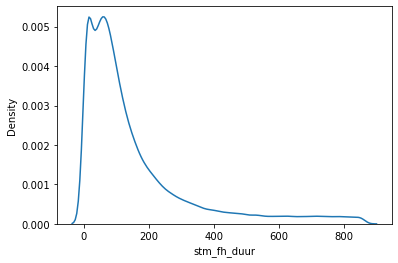

In [11]:
sns.kdeplot(new_df_copy.stm_fh_duur)

In [12]:
mean_dur_df = column_outlier('a', df.copy(), ['stm_fh_duur'])[['stm_fh_duur', 'Oorzaak']].groupby('Oorzaak', as_index = False).mean()

In [13]:
mean_dur_df

,Oorzaak,stm_fh_duur
0,Aanrijding (bijna) tijdens werkzaamheden,129.292683
1,Aanrijding met personen langs de baan,NaN
2,Aanrijding met wegverkeer,NaN
3,Afstelling onjuist/verlopen,200.818182
4,Applicatie/softwarefout,61.305848
5,Belemmerende vegetatie,203.188291
6,Bij onderzoek in orde/geen oorzaak gevonden,166.605903
7,Bijna aanrijding met persoon langs baan,57.475774
8,Bijna aanrijding met wegverkeer,92.270451
9,Braamvorming,168.352101


In [14]:
def cause_predict(cause):
    
    valid_causes = list(mean_dur_df.Oorzaak)
    if cause in valid_causes:
        estimate = float(mean_dur_df[mean_dur_df.Oorzaak == cause].stm_fh_duur)
    else:
        estimate = None
    
    return estimate

In [15]:
cause_predict('Bij onderzoek in orde/geen oorzaak gevonden')

166.60590326851838

In [16]:
test_df = new_df_copy.sample(frac=0.1)[['Oorzaak', 'stm_fh_duur']]
test_df = test_df.dropna()

y_pred = [cause_predict(x) for x in test_df.Oorzaak]
y_true = list(test_df.stm_fh_duur)

In [17]:
pd.DataFrame([abs(y_pred[i]-y_true[i]) for i in  range(len(y_pred))]).describe()


,0
count,59394.000000
mean,121.510183
std,123.143805
min,0.000174
25%,51.570217
50%,93.818182
75%,137.385113
max,798.694152


In [18]:
prog_df = df[['stm_fh_duur', 'stm_progfh_in_duur']].dropna()
test_prog_df = prog_df.copy().sample(frac=0.1)

y_pred = list(test_prog_df.stm_progfh_in_duur)
y_true = list(test_prog_df.stm_fh_duur)


In [19]:
pd.DataFrame([abs(y_pred[i]-y_true[i]) for i in  range(len(y_pred))]).describe()

,0
count,7.267800e+04
mean,1.462217e+07
std,3.532800e+07
min,0.000000e+00
25%,2.700000e+01
50%,8.700000e+01
75%,1.104000e+03
max,1.051885e+08


In [20]:
# hoe groot de bins worden die de 'stm_fh_duur' kolom verdelen
error_margin = 10

In [21]:
t_df = df[['stm_fh_duur', 'stm_progfh_in_duur']].dropna()

<h2> Wat is de kans dat de prognose in de juiste bin zit? </h2>

In [22]:
t_df['succes'] = np.where((abs(t_df['stm_fh_duur'] - (t_df['stm_progfh_in_duur']))) < error_margin, 1, 0)
t_df.succes.value_counts()[1] / t_df.succes.size

0.12815658216091638

In [23]:
p_df = df[['stm_fh_duur', 'Oorzaak']].sample(frac=0.05).dropna()

<h2> Wat is de kans dat de 'cause predict' voorspelling in de juiste bin zit? </h2>

In [24]:
p_df['pred'] = p_df.Oorzaak.apply(lambda x : cause_predict(x))
p_df['succes'] = np.where((abs(p_df['stm_fh_duur'] - (p_df['pred']))) < error_margin, 1, 0)
p_df.succes.value_counts()[1] / p_df.succes.size

0.03434703816966814

<h2> MODEL COMPARISON </h2>

In [25]:
df_co = column_outlier('a', df, ['stm_fh_duur'])
#df_co = df_co[df_co.Oorzaak == 'Braamvorming']
len(df_co)

609774

In [26]:
bins = [x for x in range(0,900,error_margin)]
labels = [x for x in range(1,len(bins))]

df_co['duration_bin'] = pd.cut(df_co['stm_fh_duur'], bins = bins, labels=labels)

In [27]:

df_co = df_co[['stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld','stm_fh_duur','duration_bin', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']].sample(frac = 1).dropna()
X = df_co[['stm_equipm_nr_mld', 'stm_prioriteit', 'stm_km_tot_mld', 'stm_rapportage_jaar','spring', 'summer','autumn','winter']]
y = df_co.duration_bin

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

len(X_train)

404213

In [28]:

# svm, random forests en gaussion process classifier duren veels te lang op deze dataset

clf = DecisionTreeClassifier(random_state=0).fit(X_train, y_train)
clf2 = KNeighborsClassifier(n_neighbors = 1).fit(X_train, y_train)


In [29]:
def get_accuracy(r,zip_list):

    return len([ _ for x in zip_list if x[0]+r >= x[1] >= x[0]-r])/len(y_test)

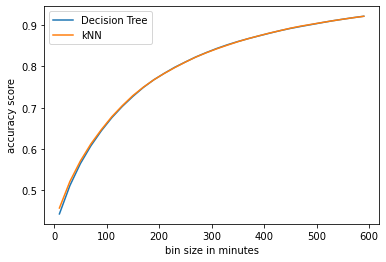

In [30]:
x_ax = [error_margin +(20*x) for x in range(0,30)]

y1_ax = [get_accuracy(x, list(zip(list(y_test), list(clf.predict(X_test))))) for x in range(0,30)]
y2_ax = [get_accuracy(x, list(zip(list(y_test), list(clf2.predict(X_test))))) for x in range(0,30)]


plt.plot(x_ax,y1_ax, label = 'Decision Tree')
plt.plot(x_ax,y2_ax, label = 'kNN')


plt.xlabel('bin size in minutes')
plt.ylabel('accuracy score')

plt.legend()
plt.show()

In [31]:
# chance to predict the right bin, decision tree
y1_ax[0]

0.4430997288578384

In [32]:
# chance to predict the right bin, KNN
y2_ax[0]

0.45738911868901777